# Import Packages

In [28]:
import os
import json
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine
from scipy.interpolate import interp1d

DATA_DIRECTORY = os.getcwd()

# Read Data

In [2]:
filepath = os.path.join(DATA_DIRECTORY, 'ETOPO1_Ice_g_geotiff.tif')
raster = rasterio.open(filepath)
raster_height = raster.read(1)
raster.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 21601, 'height': 10801, 'count': 1, 'crs': None, 'transform': Affine(0.016666666666666666, 0.0, -180.00833333333333,
       0.0, -0.016666666666666663, 90.00833333333334), 'tiled': False, 'interleave': 'band'}

# Examine Min/Max Data

In [3]:
max_height = np.amax(raster_height)
max_height_indices = np.where(raster_height == max_height)
max_height_lat_lon = raster.xy(max_height_indices[0][0], max_height_indices[1][0])

print("Max Height: ", max_height)

print("Lat Index: ", max_height_indices[1][0])
print("Lon Index: ", max_height_indices[0][0])

print("Lat: ", max_height_lat_lon[1])
print("Lon: ", max_height_lat_lon[0])

Max Height:  8271
Lat Index:  16016
Lon Index:  3721
Lat:  27.98333333333335
Lon:  86.93333333333334


In [4]:
min_height = np.amin(raster_height)
min_height_indices = np.where(raster_height == min_height)
min_height_lat_lon = raster.xy(min_height_indices[0][0], min_height_indices[1][0])

print("Min Height: ", min_height)

print("Lat Index: ", min_height_indices[1][0])
print("Lon Index: ", min_height_indices[0][0])

print("Lat: ", min_height_lat_lon[1])
print("Lon: ", min_height_lat_lon[0])

Min Height:  -10898
Lat Index:  19331
Lon Index:  4719
Lat:  11.350000000000023
Lon:  142.18333333333334


# Plot Data

In [214]:
def get_distances(index, raster, adjustment=0):
    distances = []
    for i in range(raster.height):
        if i == 0:
            distances.append(0 + adjustment)
        else:
            prev_distance = distances[i-1]
            prev_lat_lon = raster.xy(i - 1, index)
            prev_lat_lon = (prev_lat_lon[1], prev_lat_lon[0])
            current_lat_lon = raster.xy(i, index)
            current_lat_lon = (current_lat_lon[1], current_lat_lon[0])
            distance = haversine(prev_lat_lon, current_lat_lon, Unit.KILOMETERS)
            distances.append(distance + prev_distance)
    return distances

def plot_elevation_path(latitude, longitude, raster, raster_height):
    # Get the first part of the path
    raster_index = raster.index(longitude, latitude)
    lat_index = raster_index[0]
    lon_index = raster_index[1]
    latitudes = [raster.xy(i, lon_index)[1] for i in range(raster.height)]
    distances = get_distances(lon_index, raster)
    heights = [raster_height[i, lon_index] for i in range(raster.height)]
    
    # Get the other half of the path
    inv_lon = -(180 - longitude)
    inv_raster_index = raster.index(inv_lon, -latitude)
    inv_lat_index = inv_raster_index[0]
    inv_lon_index = inv_raster_index[1]
    inv_latitudes = [raster.xy(i, inv_lon_index)[1] for i in range(raster.height)]
    inv_distances = get_distances(inv_lon_index, raster, adjustment=distances[-1]+1.8532513372265385)
    inv_heights = [raster_height[i, inv_lon_index] for i in range(raster.height)]
    
    # Combine the two paths
    combined_distances = distances + inv_distances # TODO: retrieve distances after ordering lat/heights
    combined_latitudes = latitudes + inv_latitudes[::-1]
    combined_heights = heights + inv_heights[::-1]
    # Reverse the path in order
    reverse_distances = combined_distances[::-1]
    reverse_latitudes = combined_latitudes[::-1]
    reverse_heights = combined_heights[::-1]
    reverse_lat_index = len(combined_heights) - lat_index - 1
    
    axes = plt.gca()
    # Mariana Trench is 11K+ meters deep!
    axes.set_ylim([-11000,11000])
    plt.plot(combined_distances, combined_heights)
    plt.plot(
        [combined_distances[lat_index]],
        [combined_heights[lat_index]],
        marker='o',
        markersize=10,
        color="red"
    )
    return combined_distances, combined_latitudes, combined_heights, lat_index

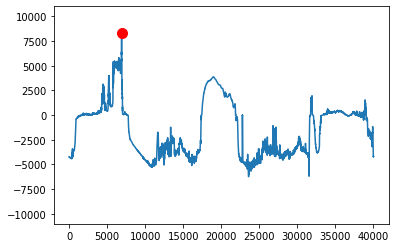

In [215]:
# Mt. Everest
lat = max_height_lat_lon[1]
lon = max_height_lat_lon[0]
d, l, h, i = plot_elevation_path(lat, lon, raster, raster_height)

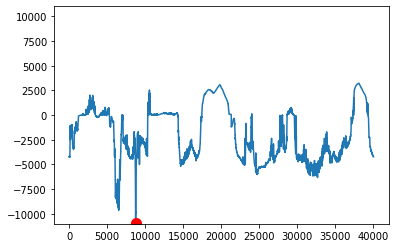

In [216]:
# Mariana Trench
lat = min_height_lat_lon[1]
lon = min_height_lat_lon[0]
d, l, h, i = plot_elevation_path(lat, lon, raster, raster_height)

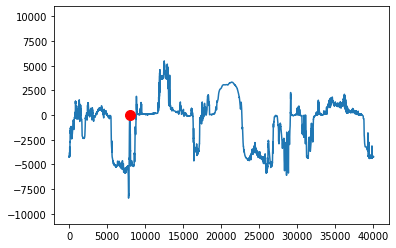

In [217]:
# Mayagüez
lat = 18.204498
lon = -67.126673
d, l, h, i = plot_elevation_path(lat, lon, raster, raster_height)

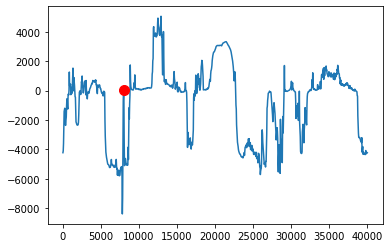

In [218]:
inew = round(i * 1000 / len(l))
xnew = np.linspace(min(d), max(d), num=1000)
f = interp1d(d, h)
ynew = f(xnew)
plt.plot(xnew,ynew)
plt.plot(
    [xnew[inew]],
    [ynew[inew]],
    marker='o',
    markersize=10,
    color="red"
)
plt.show()

# Output Test Files

In [237]:
distance_json = {
    "distance": d
}
with open("test_distance.json", "w") as f:
    json.dump(distance_json, f)

In [239]:
latitude_json = {
    "latitude": l
}
with open("test_latitude.json", "w") as f:
    json.dump(latitude_json, f)

In [244]:
elevation_json = {
    "elevation": [int(i) for i in h]
}
with open("test_elevation.json", "w") as f:
    json.dump(elevation_json, f)